<center><img src="https://i.imgur.com/zRrFdsf.png" width="700"></center>



<a target="_blank" href="https://colab.research.google.com/github/CienciaDeDatosEspacial/GeoDataFrame_SpatialOperation/blob/main/GeoDF_Operations.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Basic spatial operations in  Geo Dataframes

We will review some important operations for geodataframes. As usual, let's do this: 

1. Create a repository named: **geodf_operations**.
2. Clone that repo to a local folder in your computer.
3. In that local folder in your computer, create a folder named **maps** and **data**.
4. Download the shapefile of "Brazil - Subnational Administrative Boundaries"(bra_adm_ibge_2020_SHP.zip) from [here](https://data.humdata.org/dataset/cod-ab-bra) and save it in the maps folder (you need to unzip the file).
5. Download a **CSV** file with information on the airports in Brazil from this [website](https://data.humdata.org/dataset/ourairports-bra), Save it in my **data** folder:
6. Commit and push.

Let's remember the contents of the world map from last session:

In [1]:
linkWorldMap="https://github.com/CienciaDeDatosEspacial/intro_geodataframe/raw/main/maps/worldMaps.gpkg"


import geopandas as gpd
from  fiona import listlayers
listlayers(linkWorldMap)

['countries', 'rivers', 'cities', 'indicators']

Let's open all the layers

In [2]:
countries=gpd.read_file(linkWorldMap,layer='countries')
rivers=gpd.read_file(linkWorldMap,layer='rivers')
cities=gpd.read_file(linkWorldMap,layer='cities')
indicators=gpd.read_file(linkWorldMap,layer='indicators')

<a class="anchor" id="0"></a>

Now, let's see some important spatial operations:

1. [Subsetting](#1)
2. [Projections](#2)
3. [Combining GeoDF rows](#3)
4. [The convex hull](#4)
5. [Spatial Overlays](#5)
6. [Checking Validity](#6)




<a class="anchor" id="1"></a>

# Subsetting

## Filtering

You can keep some elements by subsetting by *filtering*, as we used to do n common pandas data frames.

In [3]:
countries.head()

,COUNTRY,geometry
0,Aruba (Netherlands),"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
1,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,Afghanistan,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."
3,Algeria,"POLYGON ((-5.15213 30.18047, -5.13917 30.19236..."
4,Azerbaijan,"MULTIPOLYGON (((46.54037 38.87559, 46.49554 38..."


In [4]:
# as DF
countries.iloc[50:,]

,COUNTRY,geometry
50,Central African Republic,"POLYGON ((20.45330 4.52379, 20.45798 4.61931, ..."
51,Cuba,"MULTIPOLYGON (((-76.94608 21.45221, -76.88390 ..."
52,Cape Verde,"MULTIPOLYGON (((-25.28139 16.91333, -25.29861 ..."
53,Cook Islands (New Zealand),"MULTIPOLYGON (((-165.84167 -10.89084, -165.848..."
54,Cyprus,"POLYGON ((33.27229 34.70955, 33.21722 34.69944..."
...,...,...
247,South Sudan,"POLYGON ((34.21807 9.96458, 34.20722 9.90500, ..."
248,Indonesia,"MULTIPOLYGON (((123.21846 -10.80917, 123.19832..."
249,East Timor,"MULTIPOLYGON (((124.41824 -9.30010, 124.40446 ..."
250,Curacao (Netherlands),"POLYGON ((-68.96556 12.19889, -68.91196 12.181..."


In [5]:
# as DF
countries.loc[50:,'geometry']

50     POLYGON ((20.45330 4.52379, 20.45798 4.61931, ...
51     MULTIPOLYGON (((-76.94608 21.45221, -76.88390 ...
52     MULTIPOLYGON (((-25.28139 16.91333, -25.29861 ...
53     MULTIPOLYGON (((-165.84167 -10.89084, -165.848...
54     POLYGON ((33.27229 34.70955, 33.21722 34.69944...
                             ...                        
247    POLYGON ((34.21807 9.96458, 34.20722 9.90500, ...
248    MULTIPOLYGON (((123.21846 -10.80917, 123.19832...
249    MULTIPOLYGON (((124.41824 -9.30010, 124.40446 ...
250    POLYGON ((-68.96556 12.19889, -68.91196 12.181...
251    POLYGON ((-68.19736 12.22264, -68.19292 12.207...
Name: geometry, Length: 202, dtype: geometry

But as a GeDF, you can also filter using a coordinate point via __cx__. Let me get the bounding box of the map:

In [6]:
countries.total_bounds

array([-180.        ,  -90.        ,  180.        ,   83.62359619])

As you are getting __[minx, miny, maxx, maxy]__ let me select a valid coordinate, i.e. (0,0)

In [7]:
countries.cx[:0,:0]

,COUNTRY,geometry
9,American Samoa (US),"POLYGON ((-170.74390 -14.37556, -170.74942 -14..."
10,Argentina,"MULTIPOLYGON (((-71.01648 -36.47591, -70.98195..."
14,Antarctica,"MULTIPOLYGON (((-45.14528 -60.76611, -45.15639..."
24,Bolivia,"POLYGON ((-62.19884 -20.47139, -62.26945 -20.5..."
29,Brazil,"MULTIPOLYGON (((-70.62862 -9.94849, -70.62889 ..."
42,Chile,"MULTIPOLYGON (((-73.61806 -51.63390, -73.60494..."
47,Colombia,"MULTIPOLYGON (((-81.71306 12.49028, -81.72014 ..."
53,Cook Islands (New Zealand),"MULTIPOLYGON (((-165.84167 -10.89084, -165.848..."
58,Jarvis Island (US),"POLYGON ((-160.02115 -0.39806, -160.02811 -0.3..."
60,Ecuador,"MULTIPOLYGON (((-78.70903 -4.58479, -78.72348 ..."


<Axes: >

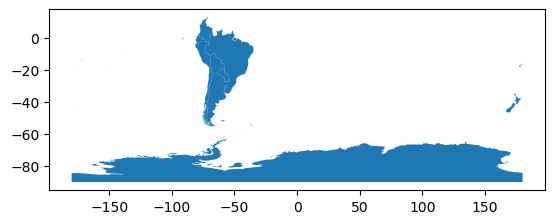

In [8]:
#then
countries.cx[:0,:0].plot()

Notice __cx__ would be cleaner if spatial element is a point.

Let me keep one country:

In [9]:
brazil=countries[countries.COUNTRY=='Brazil']

## Clipping

But you can also subset by *clipping*, as sometimes other data frames may not have the same fields for filtering:

In [10]:
citiesBrazil_clipped = gpd.clip(gdf=cities,
                          mask=brazil)
riversBrazil_clipped = gpd.clip(gdf=rivers,
                               mask=brazil)

Then, you can plot the clipped version:

<Axes: >

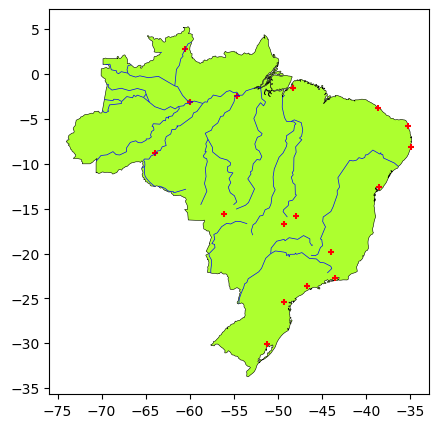

In [11]:
base = brazil.plot(facecolor="greenyellow", edgecolor='black', linewidth=0.4,figsize=(5,5))
citiesBrazil_clipped.plot(marker='+', color='red', markersize=15,
                    ax=base)
riversBrazil_clipped.plot(edgecolor='blue', linewidth=0.5,
                    ax=base)

The geometry types are not modified:

In [12]:
set(brazil.geom_type), set(citiesBrazil_clipped.geom_type), set(riversBrazil_clipped.geom_type)

({'MultiPolygon'}, {'Point'}, {'LineString', 'MultiLineString'})

### Exercise 1
<div class="alert-success">

1. Follow the same steps in this last section to plot three maps of one country. Do not use Brazil.
2. Plot your three layers.
    
</div>

[TOC](#0)
_____________

<a class="anchor" id="2"></a>

# Map Projection

The CRS is a very important property of the maps. They affect three some aspects:

* shape
* area
* scale
* direction

Most maps come with a default CRS: 4326. Pay attention:

In [13]:
brazil.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
# check units of measurement
brazil.crs.axis_info

[Axis(name=Geodetic latitude, abbrev=Lat, direction=north, unit_auth_code=EPSG, unit_code=9122, unit_name=degree),
 Axis(name=Geodetic longitude, abbrev=Lon, direction=east, unit_auth_code=EPSG, unit_code=9122, unit_name=degree)]

In [15]:
# is this CRS projected?
brazil.crs.is_projected

False

Polygons have a centroid. When we try getting a centroid from an **unprojected** polygon, you get:

In [16]:
# centroid
brazil.centroid

/var/folders/2n/bkfhfqq16r78g3hf7pdj56y40000gn/T/ipykernel_94039/515368123.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  brazil.centroid


29    POINT (-53.09009 -10.77302)
dtype: geometry

## Reprojecting

A projected CRS will have units in meters or feet (or similar). You can request a crs per country [here](https://epsg.io/?q=brazil+kind%3APROJCRS):

In [17]:
# recommended for Brazil (meters)
brazil.to_crs(5641).crs.axis_info

[Axis(name=Easting, abbrev=X, direction=east, unit_auth_code=EPSG, unit_code=9001, unit_name=metre),
 Axis(name=Northing, abbrev=Y, direction=north, unit_auth_code=EPSG, unit_code=9001, unit_name=metre)]

In [18]:
# now this works with no warning
brazil.to_crs(5641).centroid

29    POINT (3884486.179 8756856.093)
dtype: geometry

<Axes: >

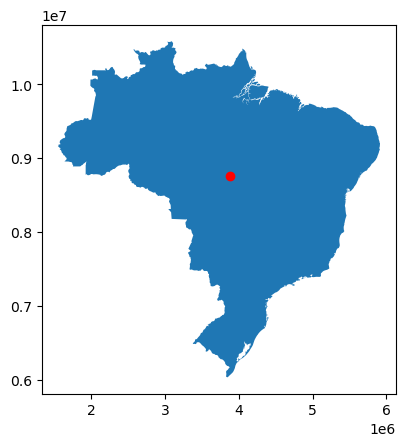

In [19]:
# replotting:

base5641=brazil.to_crs(5641).plot()
brazil.to_crs(5641).centroid.plot(color='red',ax=base5641)

Let's keep the projected version for all our maps:

In [20]:
brazil_5641=brazil.to_crs(5641)
cities_brazil_5641=citiesBrazil_clipped.to_crs(brazil_5641.crs)
rivers_brazil_5641=riversBrazil_clipped.to_crs(brazil_5641.crs)

In [21]:
## saving


import os

brazil_5641.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), layer='country', driver="GPKG")
cities_brazil_5641.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), layer='cities', driver="GPKG")
rivers_brazil_5641.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), layer='rivers', driver="GPKG")
brazil_5641.centroid.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), layer='centroid', driver="GPKG")

### Exercise 2
<div class="alert-success">

1. Reproject your country's map layers.
2. Plot the reprojected layers
3. Save the reprojected layers
    
</div>

## Creating Spatial data

You will get Lines and Polygons as maps for sure, but that may not be the case with points. Let's open the **CSV** with information on the airports in Brazil:

In [22]:
import pandas as pd
infoairports=pd.read_csv(os.path.join("data","br-airports.csv"))

# some rows

infoairports.iloc[[0,1,2,3,-4,-3,-2,-1],:] #head and tail


,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,country_name,iso_country,...,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,score,last_updated
0,#meta +id,#meta +code,#loc +airport +type,#loc +airport +name,#geo +lat,#geo +lon,#geo +elevation +ft,#region +continent +code,#country +name,#country +code +iso2,...,#loc +municipality +name,#status +scheduled,#loc +airport +code +gps,#loc +airport +code +iata,#loc +airport +code +local,#meta +url +airport,#meta +url +wikipedia,#meta +keywords,#meta +score,#date +updated
1,5910,SBGR,large_airport,Guarulhos - Governador André Franco Montoro In...,-23.431944,-46.467778,2461,SA,Brazil,BR,...,São Paulo,1,SBGR,GRU,SP0002,http://www.aeroportoguarulhos.net/,https://en.wikipedia.org/wiki/S%C3%A3o_Paulo-G...,Cumbica,1016675,2021-10-28T15:52:55+00:00
2,5906,SBGL,large_airport,Rio Galeão – Tom Jobim International Airport,-22.809999,-43.250557,28,SA,Brazil,BR,...,Rio De Janeiro,1,SBGL,GIG,RJ0001,NaN,https://en.wikipedia.org/wiki/Rio_de_Janeiro-G...,Galeão - Antônio Carlos Jobim International Ai...,51475,2021-10-14T18:09:35+00:00
3,5974,SBSP,medium_airport,Congonhas Airport,-23.627657,-46.654601,2631,SA,Brazil,BR,...,São Paulo,1,SBSP,CGH,SP0001,http://www.infraero.gov.br/usa/aero_prev_home....,https://en.wikipedia.org/wiki/Congonhas-S%C3%A...,http://www.infraero.gov.br/usa/aero_prev_home....,750,2022-05-03T20:10:35+00:00
6668,309669,SSVR,closed,Volta Redonda Airport,-22.4978,-44.085,1245,SA,Brazil,BR,...,Volta Redonda,0,NaN,NaN,NaN,NaN,NaN,"SSVR, SSVR, QVR",0,2013-09-28T14:52:12+00:00
6669,505308,BR-1760,heliport,Unimed Volta Redonda Helipad,-22.533988,-44.076918,1385,SA,Brazil,BR,...,Volta Redonda,0,SSKV,NaN,RJ0147,NaN,NaN,NaN,0,2022-12-06T21:28:25+00:00
6670,341727,BR-1429,heliport,Santa Helena Heliport,-23.59851,-47.441196,2254,SA,Brazil,BR,...,Votorantim,0,SWHE,NaN,SP0807,NaN,NaN,NaN,0,2021-03-07T10:30:07+00:00
6671,343017,BR-1493,heliport,Bandeiras Centro Empresarial Heliport,-23.536615,-47.449475,1827,SA,Brazil,BR,...,Votorantim,0,SWST,NaN,SP1306,NaN,NaN,NaN,0,2021-04-14T20:12:01+00:00


This needs some cleaning:

In [23]:
# bye first row
infoairports.drop(index=0,inplace=True)
infoairports.reset_index(drop=True, inplace=True)
infoairports.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,country_name,iso_country,...,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,score,last_updated
0,5910,SBGR,large_airport,Guarulhos - Governador André Franco Montoro In...,-23.431944,-46.467778,2461,SA,Brazil,BR,...,São Paulo,1,SBGR,GRU,SP0002,http://www.aeroportoguarulhos.net/,https://en.wikipedia.org/wiki/S%C3%A3o_Paulo-G...,Cumbica,1016675,2021-10-28T15:52:55+00:00
1,5906,SBGL,large_airport,Rio Galeão – Tom Jobim International Airport,-22.809999,-43.250557,28,SA,Brazil,BR,...,Rio De Janeiro,1,SBGL,GIG,RJ0001,NaN,https://en.wikipedia.org/wiki/Rio_de_Janeiro-G...,Galeão - Antônio Carlos Jobim International Ai...,51475,2021-10-14T18:09:35+00:00
2,5974,SBSP,medium_airport,Congonhas Airport,-23.627657,-46.654601,2631,SA,Brazil,BR,...,São Paulo,1,SBSP,CGH,SP0001,http://www.infraero.gov.br/usa/aero_prev_home....,https://en.wikipedia.org/wiki/Congonhas-S%C3%A...,http://www.infraero.gov.br/usa/aero_prev_home....,750,2022-05-03T20:10:35+00:00
3,5967,SBRJ,medium_airport,Santos Dumont Airport,-22.9105,-43.163101,11,SA,Brazil,BR,...,Rio de Janeiro,1,SBRJ,SDU,RJ0002,https://www4.infraero.gov.br/aeroportos/aeropo...,https://en.wikipedia.org/wiki/Santos_Dumont_Ai...,RIO,750,2022-03-28T23:27:00+00:00
4,5872,SBBR,large_airport,Presidente Juscelino Kubitschek International ...,-15.869167,-47.920834,3497,SA,Brazil,BR,...,Brasília,1,SBBR,BSB,DF0001,http://www.infraero.gov.br/usa/aero_prev_home....,https://en.wikipedia.org/wiki/Bras%C3%ADlia_In...,NaN,51275,2020-08-24T11:15:12+00:00


In [24]:
# keep the  columns needed

infoairports.columns


Index(['id', 'ident', 'type', 'name', 'latitude_deg', 'longitude_deg',
       'elevation_ft', 'continent', 'country_name', 'iso_country',
       'region_name', 'iso_region', 'local_region', 'municipality',
       'scheduled_service', 'gps_code', 'iata_code', 'local_code', 'home_link',
       'wikipedia_link', 'keywords', 'score', 'last_updated'],
      dtype='object')

In [25]:
keep=['name','type','latitude_deg', 'longitude_deg','elevation_ft','region_name','municipality']
infoairports=infoairports.loc[:,keep]

infoairports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6671 entries, 0 to 6670
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           6671 non-null   object
 1   type           6671 non-null   object
 2   latitude_deg   6671 non-null   object
 3   longitude_deg  6671 non-null   object
 4   elevation_ft   6500 non-null   object
 5   region_name    6671 non-null   object
 6   municipality   6647 non-null   object
dtypes: object(7)
memory usage: 364.9+ KB


Some formatting:

In [26]:
numericCols=['latitude_deg', 'longitude_deg','elevation_ft']
infoairports[numericCols]=infoairports.loc[:,numericCols].apply(lambda x:pd.to_numeric(x))

In [27]:
# now
infoairports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6671 entries, 0 to 6670
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6671 non-null   object 
 1   type           6671 non-null   object 
 2   latitude_deg   6671 non-null   float64
 3   longitude_deg  6671 non-null   float64
 4   elevation_ft   6500 non-null   float64
 5   region_name    6671 non-null   object 
 6   municipality   6647 non-null   object 
dtypes: float64(3), object(4)
memory usage: 364.9+ KB


<Axes: xlabel='longitude_deg', ylabel='latitude_deg'>

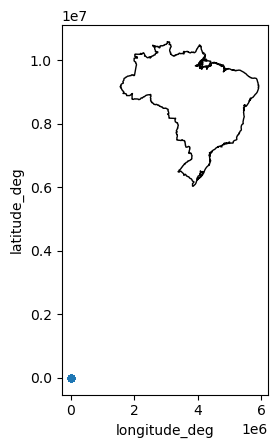

In [28]:
# let's plot

base = brazil_5641.plot(color='white', edgecolor='black') #unprojected

infoairports.plot.scatter(x = 'longitude_deg', y = 'latitude_deg',ax=base)

Why is it wrong?

<Axes: >

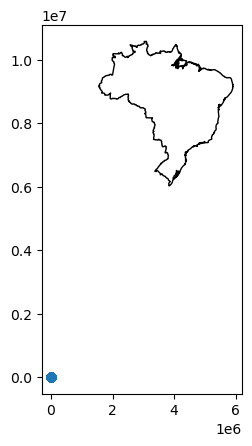

In [29]:
airports=gpd.GeoDataFrame(data=infoairports.copy(),
                 geometry=gpd.points_from_xy(infoairports.longitude_deg,
                                             infoairports.latitude_deg),
                 crs=brazil.crs.to_epsg())# the coordinates were in degrees - unprojected

# let's plot

base = brazil_5641.plot(color='white', edgecolor='black')
airports.plot(ax=base)

In [30]:
#remember:
type(airports), type(infoairports)

(geopandas.geodataframe.GeoDataFrame, pandas.core.frame.DataFrame)

Let's re project!

<Axes: >

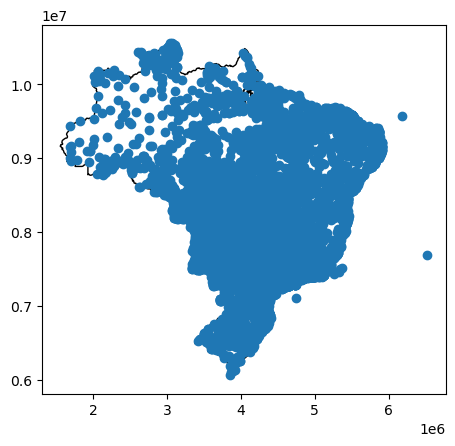

In [31]:
airports_5641=airports.to_crs(5641)

## then

base = brazil_5641.plot(color='white', edgecolor='black')
airports_5641.plot(ax=base)

Remember you have type of airports:

In [32]:
airports_5641['type'].value_counts() # this will not work: airports.type.value_counts()

small_airport     4587
heliport          1699
closed             251
medium_airport     124
large_airport        8
seaplane_base        2
Name: type, dtype: int64

We may use that in the future. For now, just rename the **type** column to a different one.

In [33]:
airports_5641.rename(columns={'type':'kind'},inplace=True)

## adding the airports to GPKG
airports_5641.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), layer='airports', driver="GPKG")

### Exercise 3
<div class="alert-success">

1. Find the airports for your country [here](https://ourairports.com/data/). The data is in a CSV file.
2. Create projected layer of airports.
3. Plot all the layers and airports on top.
    
</div>

<a class="anchor" id="11"></a>

## Formating Geoseries projections



You know **brazil_5641** is a multipolygon:

In [34]:
brazil_5641

,COUNTRY,geometry
29,Brazil,"MULTIPOLYGON (((1926257.542 8894978.397, 19262..."


Sometime, you just need the border (lines):

In [35]:
brazil_5641.boundary

29    MULTILINESTRING ((1926257.542 8894978.397, 192...
dtype: geometry

<Axes: >

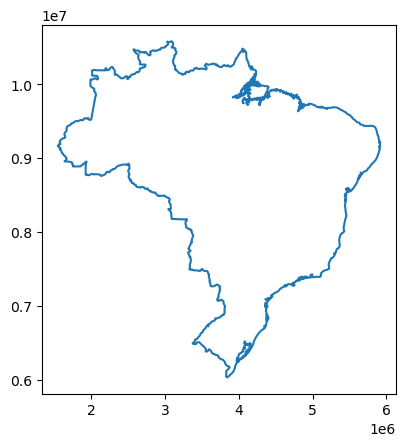

In [36]:
# This is just the borderline
brazil_5641.boundary.plot()

Always check the data type:

In [37]:
# does 'boundary' return a GDF?
type(brazil_5641.boundary)

geopandas.geoseries.GeoSeries

Some operations in geopandas require GDF or GS. If you need a GDF instead of a GS:

In [38]:
# converting into GDF
brazil_5641.boundary.to_frame()

,0
29,"MULTILINESTRING ((1926257.542 8894978.397, 192..."


Notice you get a very simple GDF, and you may want to add some information:

In [39]:
# conversion
brazil_border=brazil_5641.boundary.to_frame() 

# new column (optional)
brazil_border['name']='Brazil' 

# renaming the geometry column
brazil_border.rename(columns={0:'geometry'},inplace=True) 

#setting the geometry (the name is not enough)
brazil_border = brazil_border.set_geometry("geometry")

# verifying:
brazil_border.crs

<Projected CRS: EPSG:5641>
Name: SIRGAS 2000 / Brazil Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Brazil - offshore - equatorial margin.
- bounds: (-51.64, -5.74, -32.43, 7.04)
Coordinate Operation:
- name: Petrobras Mercator
- method: Mercator (variant B)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

You can add this GDF as a layer.

### Exercise 4

<div class="alert-success"> 
    
1. Check if your country is a polygon or multipolygon.
    
2. Recover just the boundaries of that country.
    
3. Turn the boundary into a GDF.
</div>

<a class="anchor" id="12"></a>

## Maps Lacking CRS information

Reprojecting seems a simple process, but you might find some interesting cases. Let's read the maps on _states_ and _municipalities_:

In [40]:
brazil_states=gpd.read_file(os.path.join("maps","bra_adm_ibge_2020_shp","bra_admbnda_adm1_ibge_2020.shp"))
brazil_municipalities=gpd.read_file(os.path.join("maps","bra_adm_ibge_2020_shp","bra_admbnda_adm2_ibge_2020.shp"))

They are maps, for sure:

In [41]:
type(brazil_states), type(brazil_municipalities)

(geopandas.geodataframe.GeoDataFrame, geopandas.geodataframe.GeoDataFrame)

In [42]:
brazil_states.geometry.head()

0    MULTIPOLYGON (((-68.87747 -11.01987, -68.88027...
1    POLYGON ((-35.46317 -8.82467, -35.46457 -8.828...
2    MULTIPOLYGON (((-50.46147 2.11133, -50.45627 2...
3    MULTIPOLYGON (((-58.49367 -0.84197, -58.48917 ...
4    MULTIPOLYGON (((-38.70687 -17.96447, -38.70867...
Name: geometry, dtype: geometry

In [43]:
brazil_municipalities.geometry.head()

0    POLYGON ((-62.04950 -11.86731, -62.04559 -11.8...
1    POLYGON ((-62.42279 -9.80481, -62.42688 -9.806...
2    POLYGON ((-60.37329 -13.40887, -60.37323 -13.4...
3    POLYGON ((-61.00061 -10.99219, -61.00061 -11.0...
4    POLYGON ((-61.20642 -13.08759, -61.20282 -13.0...
Name: geometry, dtype: geometry

But, notice this:

In [44]:
brazil_states.crs, brazil_municipalities.crs

(None, None)

They do not have crs information, however they can be plotted:

<Axes: >

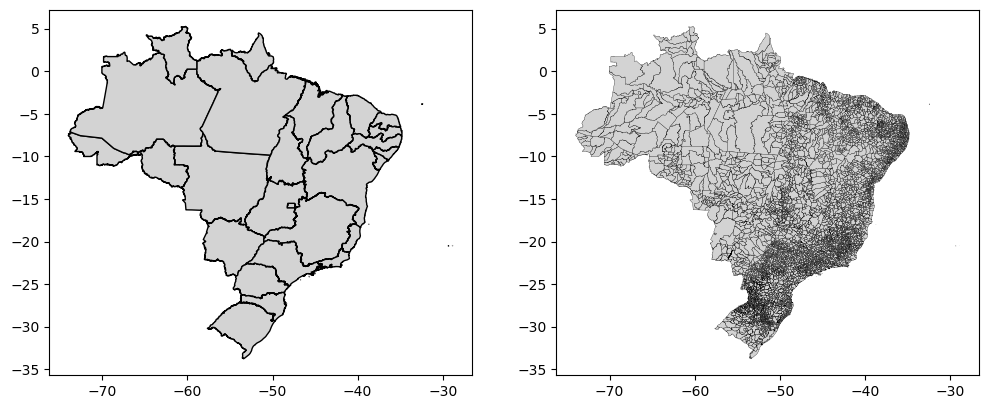

In [45]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(12,12))

brazil_states.plot(ax=ax1, facecolor='lightgrey', edgecolor='black')
brazil_municipalities.plot(ax=ax2, facecolor='lightgrey', edgecolor='black',linewidth=0.2)


Since we are using the crs 5641 for Brazil, the initial strategy could be to set the CRS with the right projection :

In [46]:
brazil_states.to_crs(5641)

ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

Python says _"Please set a crs on the object first"_. This would mean to know the actual projection, of the geometry:

From the plots above and the rows seen, we conclude the maps are unprojected; then:

In [ ]:
# set as unprojected
brazil_states.crs = "EPSG:4326"
brazil_municipalities.crs = "EPSG:4326"

Now, we can reproject:

In [ ]:
brazil_states=brazil_states.to_crs(5641)
brazil_municipalities=brazil_municipalities.to_crs(5641)

### Exercise 5 (conditional)

<div class="alert-success">

1. Look for sub administrative divisions of your country
2. Check all the CRSs of those divisions
3. If you find one CRS is missing, fill the CRS with the right projection.
</div>

[TOC](#0)
_____________


<a class="anchor" id="3"></a>

# Combining GeoDF rows

Let me divide Brazil municipalities into a higher administrative level:

In [ ]:
brazil_municipalities.plot(facecolor='lightgrey', edgecolor='black',linewidth=0.2)

In [ ]:
#see
brazil_municipalities.head()

In [ ]:
# higher level
brazil_municipalities.ADM1_PT.value_counts()

Then, this is Minas Gerais:

In [ ]:
brazil_municipalities[brazil_municipalities.ADM1_PT=='Minas Gerais'].plot()

## Unary UNION

We can combine all these polygons into one:

In [ ]:
brazil_municipalities[brazil_municipalities.ADM1_PT=='Minas Gerais'].unary_union

Let's save that result:

In [ ]:
MinasGerais_union=brazil_municipalities[brazil_municipalities.ADM1_PT=='Minas Gerais'].unary_union

In [ ]:
# what do we have?
type(MinasGerais_union)

You can turn that shapely object into a GeoDF like this:

In [ ]:
gpd.GeoDataFrame(index=[0],data={'ADM':'Minas Gerais'},
                 crs=brazil_municipalities.crs,
                 geometry=[MinasGerais_union])

<a class="anchor" id="21"></a>

## Dissolve

### a. Dissolve as Union
Using  **dissolve** is an alternative to _UNION_:

In [ ]:
brazil_municipalities[brazil_municipalities.ADM1_PT=='Minas Gerais'].dissolve().plot()

Let me save the result, and see the type :

In [ ]:
MinasGerais_dissolve=brazil_municipalities[brazil_municipalities.ADM1_PT=='Minas Gerais'].dissolve()

# we got?
type(MinasGerais_dissolve)

You got a GEOdf this time:

In [ ]:
## see
MinasGerais_dissolve

In [ ]:
# keeping what is relevant
MinasGerais_dissolve.drop(columns=['ADM2_PT','ADM2_PCODE','ET_ID'],inplace=True)

# then
MinasGerais_dissolve

### b. Dissolve for groups

Using _dissolve()_ with no arguments returns the union of the polygons, BUT also you get a GEOdf.
However, if you have a column that represents a grouping (as we do), you can dissolve by that column:

In [ ]:
# dissolving
brazil_municipalities.dissolve(by='ADM1_PT').plot(facecolor='yellow', edgecolor='black',linewidth=0.2)

Again, let me save this result:

In [ ]:
Brazil_adm1_diss=brazil_municipalities.dissolve(by='ADM1_PT')

We know we have a GeoDF; let's see contents:

In [ ]:
Brazil_adm1_diss

Again, we can drop columns that do not bring important information:

In [ ]:
Brazil_adm1_diss.drop(columns=['ADM2_PT','ADM2_PCODE','ET_ID'],inplace=True)
Brazil_adm1_diss.reset_index(inplace=True)
Brazil_adm1_diss.info()

## Exercise 6


<div class="alert-success"> 

1. Create some subset of polygons with your country data.
2. Use Unary UNION with those  polygons.
3. Create a geoDF with the result.
4. Use dissolve with the same polygons, and create a geoDF.
    
</div>

### c. Dissolve and aggregate

In pandas, you have can aggregate data using some statistics. Dissolve can be used in the same way. Let me use the _indicators_ layer:

In [ ]:
indicators.head()

We have numerical columns, and a grouping column named _region_. Let's get some averages by region, while combining the polygons:

In [ ]:
indicators.dissolve(
     by="region",
     aggfunc={
         "COUNTRY": "count",
         "fragility": ["mean"],
         "co2": ["mean"],
         "ForestRev_gdp": ["mean"]
     },as_index=False,
 )

Let me save and plot:

In [ ]:
indicatorsByRegion=indicators.dissolve(
     by="region",
     aggfunc={
         "COUNTRY": "count",
         "fragility": ["mean"],
         "co2": ["mean"],
         "ForestRev_gdp": ["mean"]
     },as_index=False,
 )


indicatorsByRegion.plot(column = 'region')

Without renaming, you can request a choropleth:

In [ ]:
indicatorsByRegion.plot(column =('fragility', 'mean'),scheme='quantiles', cmap='OrRd',
                        legend=True,
                        legend_kwds={"title": "Fragility",'loc': 'lower left'},
                        edgecolor='black',linewidth=0.2,
                        figsize=(15, 10))

[TOC](#0)
_____________


<a class="anchor" id="4"></a>

# The convex hull

Some time you may have the need to create a polygon that serves as an envelope to a set of points.

For this example, let me compute the centroid coordinates:

In [ ]:
brazil_5641.centroid

In [ ]:
# then
brazil_5641.centroid.x.values[0],brazil_5641.centroid.y.values[0]

In [ ]:
airports_5641

In [ ]:
# coordinates
centroidX,centroidY=brazil_5641.centroid.x.values[0],brazil_5641.centroid.y.values[0]

# subsets of medium airports
Brazil_AirTopLeft=airports_5641[airports_5641.kind=='medium_airport'].cx[:centroidX,centroidY:]
Brazil_AirTopRight=airports_5641[airports_5641.kind=='medium_airport'].cx[centroidX:,centroidY:]
Brazil_AirBottomLeft=airports_5641[airports_5641.kind=='medium_airport'].cx[:centroidX,:centroidY]
Brazil_AirBottomRight=airports_5641[airports_5641.kind=='medium_airport'].cx[centroidX:,:centroidY]

Let me plot the subsets:

In [ ]:
base=Brazil_AirTopLeft.plot(facecolor='grey', alpha=0.4)
Brazil_AirTopRight.plot(ax=base,facecolor='orange', alpha=0.4)
Brazil_AirBottomLeft.plot(ax=base,facecolor='green', alpha=0.4)
Brazil_AirBottomRight.plot(ax=base,facecolor='red', alpha=0.4)

Notice we have simple points in each subset:

In [ ]:
Brazil_AirBottomLeft

In this situation, you can not make a _convex hull_:

In [ ]:
Brazil_AirBottomLeft.convex_hull.plot()

You first need to dissolve, and then you create a hull, an envelope of  convex angles:

In [ ]:
Brazil_AirBottomLeft.dissolve().convex_hull.plot()

As we saw, the convex hull is a polygon: 

In [ ]:
Brazil_AirBottomLeft.dissolve().convex_hull

What if we the polygons had not been previously combined?

In [ ]:
brazil_municipalities.cx[:centroidX,:centroidY].convex_hull.plot(edgecolor='red')

That is, you get a convex hull for each geometry. 

We can also use _union_ before creating a convex hull:

In [ ]:
# just the union
large_airport=airports_5641[airports_5641.kind=='large_airport']
large_airport.unary_union

In [ ]:
# hull of the union
large_airport.unary_union.convex_hull

Let's turn the GS into a GDF:

In [ ]:
LargeAirport_hull= gpd.GeoDataFrame(index=[0],
                                    crs=large_airport.crs,
                                    geometry=[large_airport.unary_union.convex_hull])
LargeAirport_hull['name']='large airports hull' # optional

# then

LargeAirport_hull

Let's use the GDF in plotting:

In [ ]:
base=brazil_5641.plot(facecolor='yellow')
large_airport.plot(ax=base)
LargeAirport_hull.plot(ax=base,facecolor='green',
                       edgecolor='white',alpha=0.4,
                       hatch='X')

### Exercise 7 

<div class="alert-success">

1. Select some points from your maps.
    
2. Create the convex hull for those points.
    
3. Turn the hull into a GDF.
    
4. Plot the hull on top of the country.
    
</div>

[TOC](#0)
_____________

<a class="anchor" id="5"></a>
# Spatial Overlay

We might need to create or find some geometries from the geometries we already have. Using a set theory approach, we will se the use of _intersection_, _union_, _difference_, and _symmetric difference_.

Let me create this GeoDFs:

In [ ]:
# the north
MunisN_brazil=brazil_municipalities.cx[:,centroidY:]
# the south
MunisS_brazil=brazil_municipalities.cx[:,:centroidY]
# the west
MunisW_brazil=brazil_municipalities.cx[:centroidX,:]
# the east
MunisE_brazil=brazil_municipalities.cx[centroidX:,:]

Let me plot:

In [ ]:
base=MunisN_brazil.plot(facecolor='yellow', edgecolor='black',linewidth=0.2, alpha=0.6)
MunisS_brazil.plot(facecolor='grey', edgecolor='black',linewidth=0.2,ax=base, alpha=0.4)

In [ ]:
base=MunisE_brazil.plot(facecolor='yellow', edgecolor='black',linewidth=0.2, alpha=0.6)
MunisW_brazil.plot(facecolor='grey', edgecolor='black',linewidth=0.2,ax=base, alpha=0.4)

## Intersection

We keep what is common between GeoDFs:

In [ ]:
munisNS_brazil=MunisN_brazil.overlay(MunisS_brazil, how="intersection",keep_geom_type=True)
munisNS_brazil.plot()

This is similar to a _spatial join_:

In [ ]:
MunisN_brazil.sjoin(MunisS_brazil, how="inner", predicate='contains').plot()

In [ ]:
# keeping the overlay
munisWE_brazil=MunisW_brazil.overlay(MunisE_brazil, how="intersection",keep_geom_type=True)
munisWE_brazil.plot(edgecolor='white',linewidth=0.1)

## Union

Let me unite the previous two GeoDFs. First, take a look at each one:

In [ ]:
munisNS_brazil.info()

In [ ]:
munisWE_brazil.info()

The overlay combines the geometries, but not the attributes. Let me subset and show you:

In [ ]:
keep=['ADM0_EN_1','ADM1_PT_1','ADM2_PT_1','geometry']
munisNS_brazil=munisNS_brazil.loc[:,keep]
munisWE_brazil=munisWE_brazil.loc[:,keep]

In [ ]:
# now 
munisNS_brazil.overlay(munisWE_brazil,how="union",keep_geom_type=True)

As you see, geometries are fine, but not attributes. It is strictly NOT appending the GeoDFs:

In [ ]:
# appending
pd.concat([munisNS_brazil,munisWE_brazil],ignore_index=True)

You will append if you are interested in the keeping the attributes. But you just do the overlay if you are planing to combine final results:

In [ ]:
munisNS_brazil.dissolve().overlay(munisWE_brazil.dissolve(), how="union",keep_geom_type=True).dissolve().plot()

Let me create an object to save the previous result:

In [ ]:
muniMidBrazil=munisNS_brazil.dissolve().overlay(munisWE_brazil.dissolve(), how="union",keep_geom_type=True).dissolve()
muniMidBrazil

In [ ]:
# some cleaning

muniMidBrazil['zone']='middles'
muniMidBrazil=muniMidBrazil.loc[:,['ADM0_EN_1_1','zone','geometry']]   
muniMidBrazil

## Difference

Here, you keep what belongs to the GeoDF to left that is not in the GeoDF to the right:

In [ ]:
# with the municipalities
brazil_municipalities.overlay(muniMidBrazil, how='difference').plot()

## Symmetric Difference

This is the opposite to *intersection*, you keep what is not in the intersection:

In [ ]:
MunisN_brazil.overlay(MunisS_brazil, how="symmetric_difference",keep_geom_type=False).plot()

In [ ]:
MunisW_brazil.overlay(MunisE_brazil, how="symmetric_difference",keep_geom_type=False).plot()

# Exercise 8 

<div class="alert-success">

1. Apply two of these operations to your maps.
2. Apply two of these operations to the  next maps:
        
</div>

In [ ]:
# hulls for the mid size airports:
Brazil_AirTopLeft_hull=Brazil_AirTopLeft.dissolve().convex_hull
Brazil_AirTopRight_hull=Brazil_AirTopRight.dissolve().convex_hull
Brazil_AirBottomLeft_hull=Brazil_AirBottomLeft.dissolve().convex_hull
Brazil_AirBottomRight_hull=Brazil_AirBottomRight.dissolve().convex_hull

In [ ]:
base = brazil_5641.plot(color='white', edgecolor='black') #unprojected
muniMidBrazil.plot(ax=base,facecolor='magenta',alpha=0.4) #unprojected
LargeAirport_hull.plot(ax=base,facecolor='purple',alpha=0.4)
Brazil_AirTopLeft_hull.plot(ax=base,facecolor='grey', alpha=0.4)
Brazil_AirTopRight_hull.plot(ax=base,facecolor='orange', alpha=0.4)
Brazil_AirBottomLeft_hull.plot(ax=base,facecolor='green', alpha=0.4)
Brazil_AirBottomRight_hull.plot(ax=base,facecolor='red', alpha=0.4)

[TOC](#0)
_____________

<a class="anchor" id="6"></a>

# Validity of Geometry

Geometries are created in a way that some issues may appear, especially in (multi) polygons.
Let's check if our recent maps on states and municipalities are valid:

In [ ]:
# non valid
brazil_municipalities[~brazil_municipalities.is_valid]

In [ ]:
# see the invalid:
brazil_municipalities[~brazil_municipalities.is_valid].plot()

It is difficult to see what is wrong. Let's get some information:

In [ ]:
# what is wrong?

from shapely.validation import explain_validity, make_valid

explain_validity(brazil_municipalities[~brazil_municipalities.is_valid].geometry)

In [ ]:
# varieties?
brazil_municipalities['validity']=[x.split('[')[0] for x in brazil_municipalities.geometry.apply(lambda x: explain_validity(x))]
brazil_municipalities['validity'].value_counts()

In [ ]:
# solving the issue:
brazil_municipalities.drop(columns=['validity'],inplace=True)

brazil_municipalities_valid=brazil_municipalities.copy()

brazil_municipalities_valid['geometry'] = [make_valid(row)  if not row.is_valid else row for row in brazil_municipalities_valid['geometry'] ]
#any invalid?
brazil_municipalities_valid[~brazil_municipalities_valid.is_valid]

The _solution_ we got may help for some advanced techniques, but may also give us some extra trouble. Notice that once geopandas solved the problem, you  have created **collections**:

In [ ]:
pd.Series([type(x) for x in brazil_municipalities_valid.geometry]).value_counts()

However, the pressence of collections may be troublesome in shapefiles.